首先说明一下，这一节其实与EM没多大关系，只是想对GMM的分类作一个实现并推导它与LogisticRegression之间的关系
### 一.分类原理
分类实现的原理非常简单，对每一个类训练一个高斯模型模型（如果你喜欢，多个也是可以的，这里你就可以使用用EM算法了，将前面的GMMCluster简单封装一下就可以）即可，然后每个类的权重由其样本所占比例确定

In [1]:
import os
os.chdir('../')
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
# from ml_models.em import GMMCluster

"""
利用GMMCluster实现分类，代码封装到ml_models.em
"""

class GMMClassifier(object):
    def __init__(self, cluster_each_class=1, n_iter=100, tol=1e-3, shr_cov=False):
        """
        :param cluster_each_class:每个类需要几个高斯模型去拟合，默认1个
        :param n_iter:迭代次数
        :param tol: -log likehold增益<tol时，停止训练
        :param shr_cov:是否共享协方差矩阵
        """
        self.cluster_each_class = cluster_each_class
        self.n_iter = n_iter
        self.tol = tol
        self.shr_cov = shr_cov
        self.models = []

    def fit(self, X, y):
        for y_index in range(y.max() + 1):
            new_X = X[y == y_index]
            print(new_X.shape)
            cluster = GMMCluster(n_components=self.cluster_each_class, tol=self.tol, n_iter=self.n_iter)
            cluster.fit(new_X)
            self.models.append(cluster)
        if self.shr_cov:
            # 获取所有的协方差矩阵
            sigmas = []
            for model in self.models:
                params = model.params
                for param in params:
                    sigmas.append(param[2])
            # 求平均
            ave_sigma = np.mean(sigmas, axis=0)
            # 更新
            for model in self.models:
                params = model.params
                for param in params:
                    param[2] = ave_sigma

    def predict_proba(self, X):
        W = np.asarray([model.predict_sample_generate_proba(X) for model in self.models]).T
        W = W / np.sum(W, axis=1, keepdims=True)
        return W

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

In [2]:
#定义高维高斯函数
def gaussian_nd(x,u,sigma):
    return 1.0/(np.power(2*np.pi,x.shape[1]/2)*np.sqrt(np.linalg.det(sigma)))*np.exp(np.sum(-0.5*(x-u).dot(np.linalg.inv(sigma))*(x-u),axis=1))

In [3]:
#封装到utils中
def plot_contourf(data,func,lines=3):
    n = 256
    x = np.linspace(data[:,0].min(), data[:,0].max(), n)
    y = np.linspace(data[:,1].min(), data[:,1].max(), n)
    X, Y = np.meshgrid(x,y)
    C = plt.contour(X,Y, func(np.c_[X.reshape(-1),Y.reshape(-1)]).reshape(X.shape), lines, colors='g', linewidth=0.5)
    plt.clabel(C, inline=True, fontsize=10)
    plt.scatter(data[:,0],data[:,1])

In [4]:
class GMMCluster(object):
    def __init__(self, n_components=1, tol=1e-5, n_iter=100, verbose=True):
        """
        使用EM训练GMM
        :param n_components: 高斯混合模型数量
        :param tol: -log likehold增益<tol时，停止训练
        :param n_iter: 最多迭代次数
        :param verbose: 是否可视化训练过程
        """
        self.n_components = n_components
        self.tol = tol
        self.n_iter = n_iter
        self.verbose = verbose
        # 高斯模型参数
        self.params = []

    def fit(self, X):
        n_sample, _ = X.shape
        # 初始化参数
        u = np.mean(X, axis=0)
        sigma = np.cov(X.T)
        alpha = 1.0 / self.n_components
        max_value = X.max()
        min_value = X.min()
        for _ in range(0, self.n_components):
            # 每个高斯模型的权重初始化一样
            # 每个高斯模型的均值在整体均值的基础上添加一个随机的bias
            # 方差初始化一样，使用整体的方差
            self.params.append([alpha, u + np.random.random() * (max_value + min_value) / 2, sigma])
        # 计算当前的隐变量
        W = np.asarray([gaussian_nd(X, u, sigma) * alpha for alpha, u, sigma in self.params]).T  #（400，4）
        print(W.shape,W[-1])
        # 记录当前的log like hold
        current_log_loss = np.log(W.sum(axis=1)).sum() / n_sample
        print("++++",current_log_loss)
        Q = np.sum(W, axis=1, keepdims=True)
        print(Q.shape,Q[-1])
        P = np.sum(W, axis=0, keepdims=True)
        print("----",P.shape,P[-2:])
        W = W / np.sum(W, axis=1, keepdims=True) # 归一化
        print(W.shape,W[-1])
        # 迭代训练
        for _ in range(0, self.n_iter):
            if self.verbose is True:
                plot_contourf(X, lambda x: np.sum(
                    [alpha *gaussian_nd(x, u, sigma) for alpha, u, sigma in self.params], axis=0), lines=5)
                plt.pause(0.1)
                plt.clf()
            # 更新高斯模型参数
            for k in range(0, self.n_components):
                self.params[k][0] = W[:, k].sum() / n_sample  # 更新alpha
#                 print("====",W[:, k].shape)
                self.params[k][1] = np.sum(W[:, [k]] * X, axis=0) / W[:, k].sum()  # 更新均值
#                 print((W[:, [k]]*X).shape)
                self.params[k][2] = np.sum(
                    [W[i, k] * (X[[i]] - self.params[k][1]).T.dot(X[[i]] - self.params[k][1]) for i in
                     range(0, n_sample)], axis=0) / W[:, k].sum()  # 更新方差
            # 更新当前的隐变量
            W = np.asarray([gaussian_nd(X, u, sigma) * alpha for alpha, u, sigma in self.params]).T
            # 计算log like hold
            new_log_loss = np.log(W.sum(axis=1)).sum() / n_sample
            W = W / np.sum(W, axis=1, keepdims=True)
            if new_log_loss - current_log_loss > self.tol:
                current_log_loss = new_log_loss
            else:
                break
        if self.verbose:
            plot_contourf(X, lambda x: np.sum(
                [alpha * gaussian_nd(x, u, sigma) for alpha, u, sigma in self.params], axis=0), lines=5)
            plt.show()

    def predict_proba(self, X):
        # 预测样本在几个高斯模型上的概率分布
        W = np.asarray([gaussian_nd(X, u, sigma) * alpha for alpha, u, sigma in self.params]).T
        W = W / np.sum(W, axis=1, keepdims=True)
        return W

    def predict(self, X):
        # 预测样本最有可能产生于那一个高斯模型
        return np.argmax(self.predict_proba(X), axis=1)

    def predict_sample_generate_proba(self, X):
        # 返回样本的生成概率
        W = np.asarray([gaussian_nd(X, u, sigma) * alpha for alpha, u, sigma in self.params]).T
        return np.sum(W, axis=1)

In [5]:
#造数据
from sklearn.datasets import make_blobs
# from ml_models import utils

X, y = make_blobs(n_samples=400, centers=4, cluster_std=0.85, random_state=0)
X = X[:, ::-1]
print(X.shape)
y.shape

(400, 2)


(400,)

In [6]:
"""
绘制决策边界
"""


def plot_decision_function(X, y, clf, support_vectors=None):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor='k')
    # 绘制支持向量
    if support_vectors is not None:
        plt.scatter(X[support_vectors, 0], X[support_vectors, 1], s=80, c='none', alpha=0.7, edgecolor='red')

(100, 2)
(100, 1) [0.0452521]
++++ -3.09572208956281
(100, 1) [0.0452521]
---- (1, 1) [[7.67113383]]
(100, 1) [1.]


D:\Python\Anaconda3\envs\tf23\lib\site-packages\ipykernel_launcher.py:7: UserWarning: The following kwargs were not used by contour: 'linewidth'
  import sys


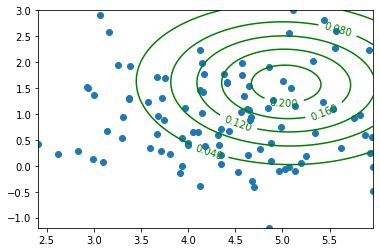

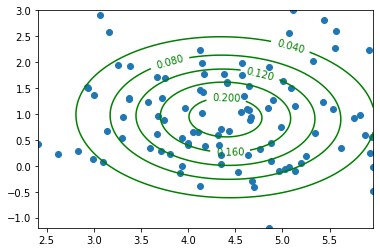

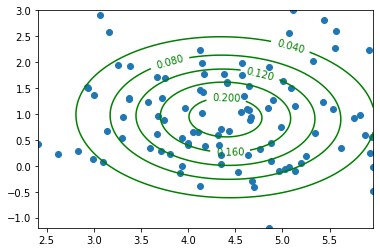

(100, 2)
(100, 1) [0.00235767]
++++ -3.7263095147772587
(100, 1) [0.00235767]
---- (1, 1) [[6.64047077]]
(100, 1) [1.]


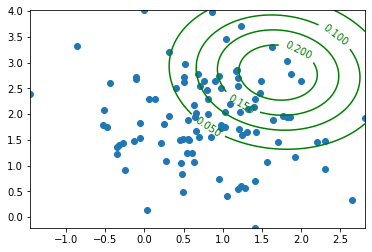

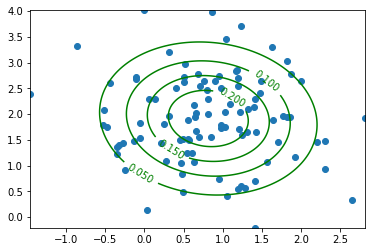

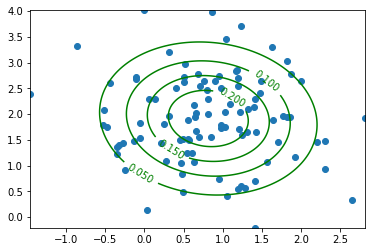

(100, 2)
(100, 1) [0.01544186]
++++ -2.8684819840819933
(100, 1) [0.01544186]
---- (1, 1) [[9.12674049]]
(100, 1) [1.]


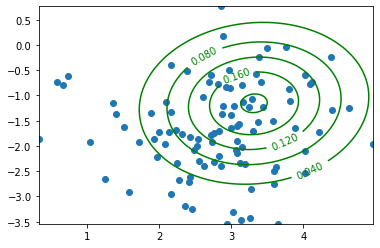

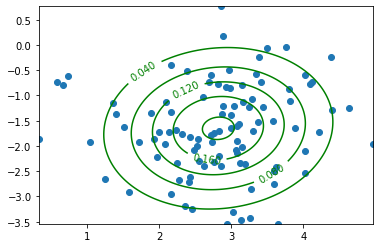

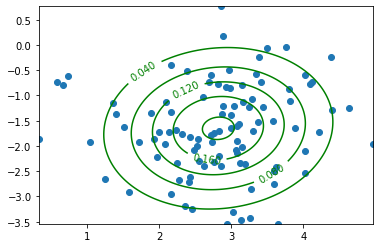

(100, 2)
(100, 1) [0.04071942]
++++ -3.376044325438113
(100, 1) [0.04071942]
---- (1, 1) [[7.67483329]]
(100, 1) [1.]


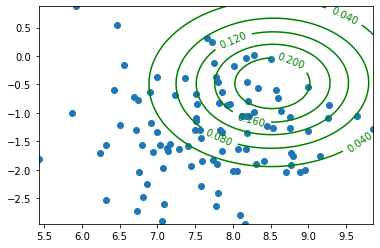

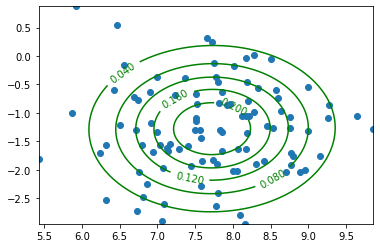

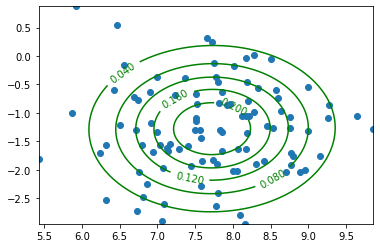

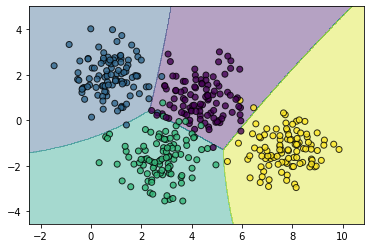

In [7]:
#训练模型并可视化
gmm = GMMClassifier(n_iter=100)
gmm.fit(X, y)
plot_decision_function(X, y, gmm)

代码里面添加了一个`shr_cov`的超参，如果`shr_cov=True`表示所有的模型都会共享同一个协方差矩阵，我们接下来看看会发生什么

(100, 2)
(100, 1) [0.0449509]
++++ -3.100876749851779
(100, 1) [0.0449509]
---- (1, 1) [[7.65112616]]
(100, 1) [1.]


D:\Python\Anaconda3\envs\tf23\lib\site-packages\ipykernel_launcher.py:7: UserWarning: The following kwargs were not used by contour: 'linewidth'
  import sys


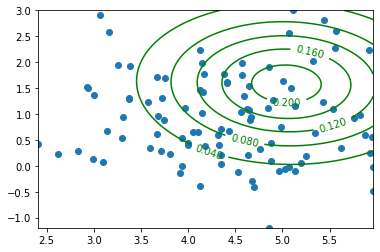

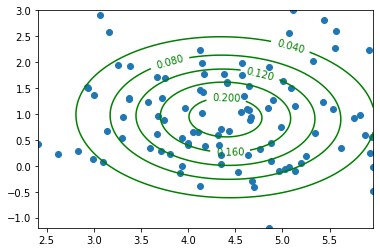

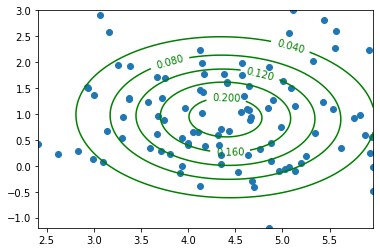

(100, 2)
(100, 1) [0.01202926]
++++ -2.858996346447197
(100, 1) [0.01202926]
---- (1, 1) [[10.09142968]]
(100, 1) [1.]


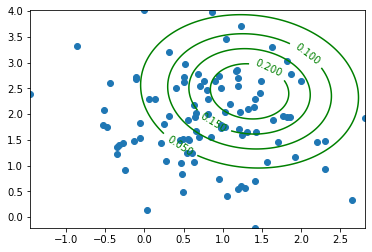

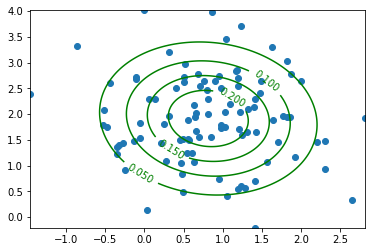

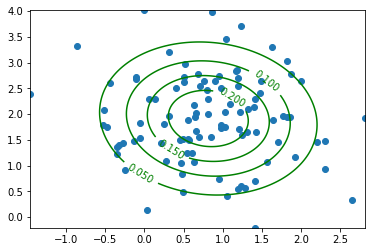

(100, 2)
(100, 1) [0.00536982]
++++ -2.5787412574978923
(100, 1) [0.00536982]
---- (1, 1) [[10.44094664]]
(100, 1) [1.]


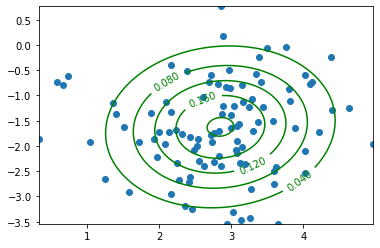

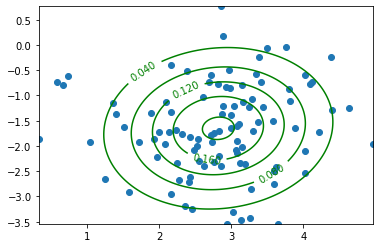

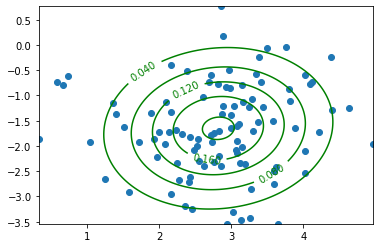

(100, 2)
(100, 1) [1.10512508e-06]
++++ -14.556470506737739
(100, 1) [1.10512508e-06]
---- (1, 1) [[0.00773857]]
(100, 1) [1.]


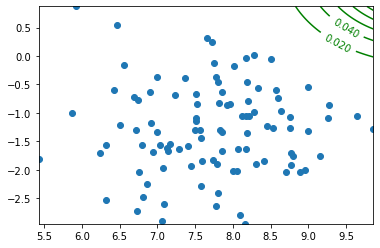

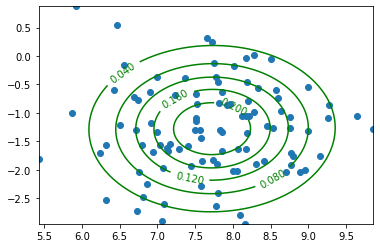

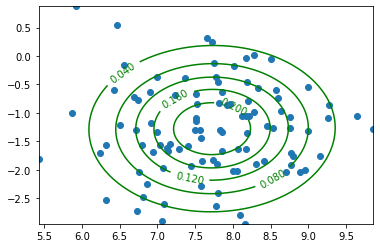

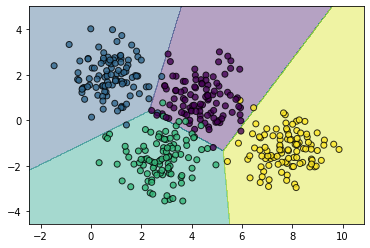

In [8]:
gmm = GMMClassifier(n_iter=100,shr_cov=True)
gmm.fit(X, y)
plot_decision_function(X, y, gmm)

可以发现类与类的边界都变成了**直线**，这时的GMM模型似乎退化成了一个线性模型，这是为什么呢？它这时其实是一个带有一定约束的LogisticRegression模型，接下来我们推推看它们之间的关系

### 二.协方差矩阵共享的GMM模型与LogisticRegression的关系
以二分类为例进行推导，假如我们训练好了两个分类模型，分别为$C_1,C_2$，那么有：   

$$
p(x\mid C_1)=N(x\mid u_1,\Sigma)\\
p(x\mid C_2)=N(x\mid u_2,\Sigma)\\
p(C_1)+p(C_2)=1
$$   
所以，高斯混合模型：   

$$
p(x)=p(C_1)p(x\mid C_1)+p(C_2)p(x\mid C_2)
$$  

接下来，我们转换为判断模型的形式：   

$$
p(C_1\mid x)=\frac{p(C_1)p(x\mid C_1)}{p(x)}\\
=\frac{p(C_1)p(x\mid C_1)}{p(C_1)p(x\mid C_1)+p(C_2)p(x\mid C_2)}\\
=\frac{1}{1+exp(-Z)}
$$   

这里$Z=log\frac{p(C_1)p(x\mid C_1)}{p(C_2)p(x\mid C_2)}$，这里已经看到了LogisticRegression的雏形了，接着，我们将$Z$化简看看：  

$$
Z=log\frac{p(C_1)p(x\mid C_1)}{p(C_2)p(x\mid C_2)}\\
=log\frac{p(x\mid C_1)}{p(x\mid C_2)}+log\frac{p(C_1)}{p(C_2)}\\
=....省略....\\
=(u_1-u_2)^T\Sigma^{-1}x-\frac{1}{2}u_1^T\Sigma^{-1}u_1+\frac{1}{2}u_2^T\Sigma^{-1}u_2+log\frac{N_1}{N_2}(N_1,N_2表示1,2类的样本量\frac{p(C_1)}{p(C_2)}=\frac{N_1}{N_2})
$$  

所以，如果令：  
$$
w^T=(u_1-u_2)^T\Sigma^{-1}\\
b=-\frac{1}{2}u_1^T\Sigma^{-1}u_1+\frac{1}{2}u_2^T\Sigma^{-1}u_2+log\frac{N_1}{N_2}
$$  

那么：  

$$
Z=w^Tx+b
$$  

那么：  

$$
p(C_1\mid x)=\frac{1}{1+exp(-w^Tx-b)}
$$  

所以，如果数据量大没必要去训练一个复杂的GMM分类器，就训练一个LR就好啦...